# Actividad 17: Clustering jerárquico (exploración)

Aquí probé clustering jerárquico con variables ambientales de la Laguna de Términos.  
La idea es estandarizar variables, construir el dendrograma y jugar con:
- el número de clusters (p. ej., 3 vs 4), y  
- el método de enlace (ward, single, complete, average).

Al final guardo una tabla con la etiqueta de cluster.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib import colormaps

# Leer datos
CO2Data = pd.read_csv("../data/Terminos_lagoon_TA_DIC_2023_RawData.csv")

# Variables para el clustering (ajusta si alguna no existe)
vars_cluster = [
    'depth_m', 'do_mg_l', 'sal_psu',
    'turbidity_fnu', 'temp_c',
    'ta_micromol_kg', 'dic_micromol_kg'
]

CO2Data[vars_cluster].head()


,depth_m,do_mg_l,sal_psu,turbidity_fnu,temp_c,ta_micromol_kg,dic_micromol_kg
0,0.464,7.12,3.56,1.47,28.740,3863,3915
1,7.792,4.90,16.97,95.33,29.028,3685,3698
2,0.453,6.99,8.94,5.50,29.283,3708,3724
3,1.261,6.52,13.87,13.44,29.024,3992,3667
4,0.465,6.24,28.06,3.60,28.202,3023,2928


In [4]:
def preprocess_data(df: pd.DataFrame, variables: list):
    """
    Estandariza las variables seleccionadas y devuelve:
    - df_clean: DataFrame sin NaNs en esas columnas
    - X_scaled: matriz estandarizada (numpy array)
    """
    df_clean = df.dropna(subset=variables).copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clean[variables])
    return df_clean, X_scaled

def perform_hierarchical_clustering(X_scaled, method: str = 'ward', n_clusters: int = 3):
    """
    Corre clustering jerárquico y regresa:
    - linkage_matrix: matriz de enlaces
    - cluster_labels: arreglo con etiquetas de cluster (1..n_clusters)
    """
    Z = linkage(X_scaled, method=method)
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    return Z, labels

def plot_dendrogram(linkage_matrix, labels=None, n_clusters: int = 3, title: str = ""):
    """
    Dibuja dendrograma. `labels` suelen ser nombres de estaciones o muestras.
    """
    plt.figure(figsize=(10, 5))
    dendrogram(
        linkage_matrix,
        labels=labels,
        above_threshold_color='gray'
    )
    plt.title(title if title else f'Dendrograma jerárquico (k={n_clusters})')
    plt.xlabel('Muestras')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()


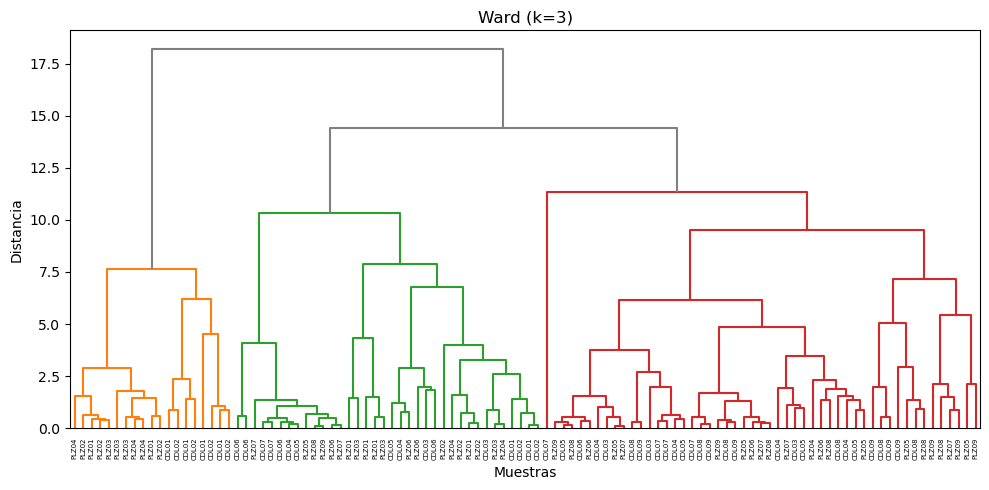

  station   area season  cluster_k3
0   CDL01  River    Dry           1
1   CDL01  River    Dry           1
2   CDL02  River    Dry           1
3   CDL02  River    Dry           1
4   CDL03  River    Dry           3


In [5]:
# Preprocesar
df_clean, X_scaled = preprocess_data(CO2Data, vars_cluster)

# Etiquetas para el dendrograma (usa 'station' si existe; si no, el índice)
if 'station' in df_clean.columns:
    labels = df_clean['station'].astype(str).tolist()  # <- lista, no Series
else:
    labels = df_clean.index.astype(str).tolist()       # <- lista, no Series

# Caso base: método Ward, 3 clusters
Z3, lab3 = perform_hierarchical_clustering(X_scaled, method='ward', n_clusters=3)
plot_dendrogram(Z3, labels=labels, n_clusters=3, title='Ward (k=3)')

# Adjuntar etiquetas de cluster al DataFrame y echar un vistazo
df_clusters_3 = df_clean.copy()
df_clusters_3['cluster_k3'] = lab3

cols_preview = [c for c in ['station','area','season','cluster_k3'] if c in df_clusters_3.columns]
print(df_clusters_3[cols_preview].head())


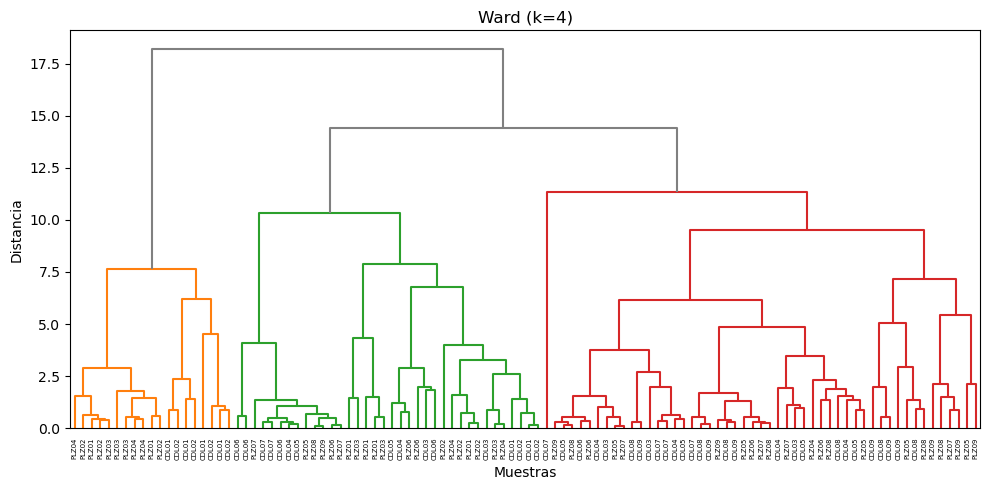

  station   area season  cluster_k4
0   CDL01  River    Dry           1
1   CDL01  River    Dry           1
2   CDL02  River    Dry           1
3   CDL02  River    Dry           1
4   CDL03  River    Dry           3


In [6]:
# Asegura etiquetas como lista
if 'station' in df_clean.columns:
    labels_k4 = df_clean['station'].astype(str).tolist()
else:
    labels_k4 = df_clean.index.astype(str).tolist()

# Ward con k=4
Z4, lab4 = perform_hierarchical_clustering(X_scaled, method='ward', n_clusters=4)
plot_dendrogram(Z4, labels=labels_k4, n_clusters=4, title='Ward (k=4)')

# Vista rápida de asignaciones
df_clusters_4 = df_clean.copy()
df_clusters_4['cluster_k4'] = lab4
cols_preview = [c for c in ['station','area','season','cluster_k4'] if c in df_clusters_4.columns]
print(df_clusters_4[cols_preview].head())


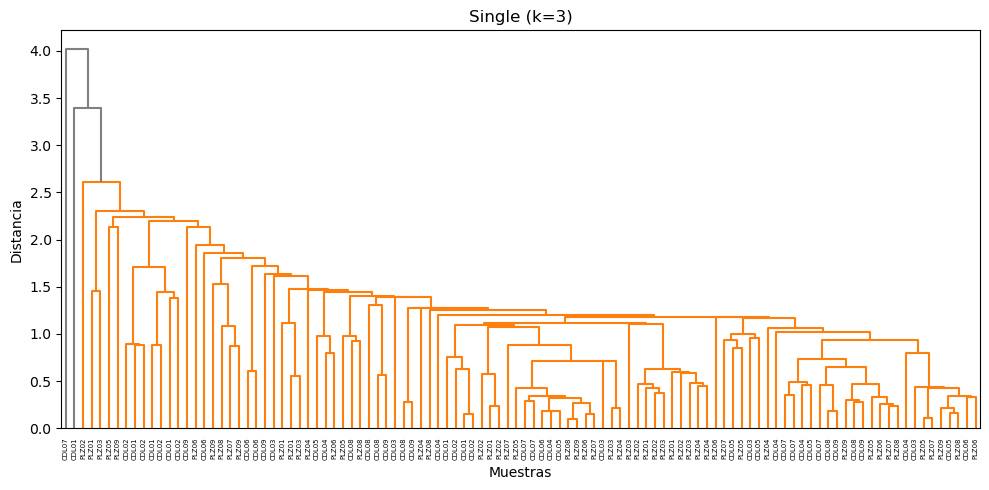

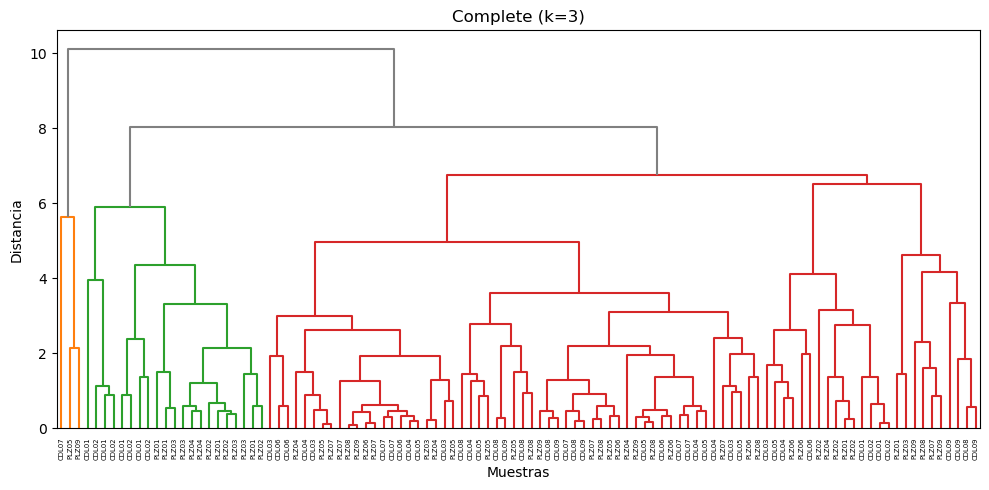

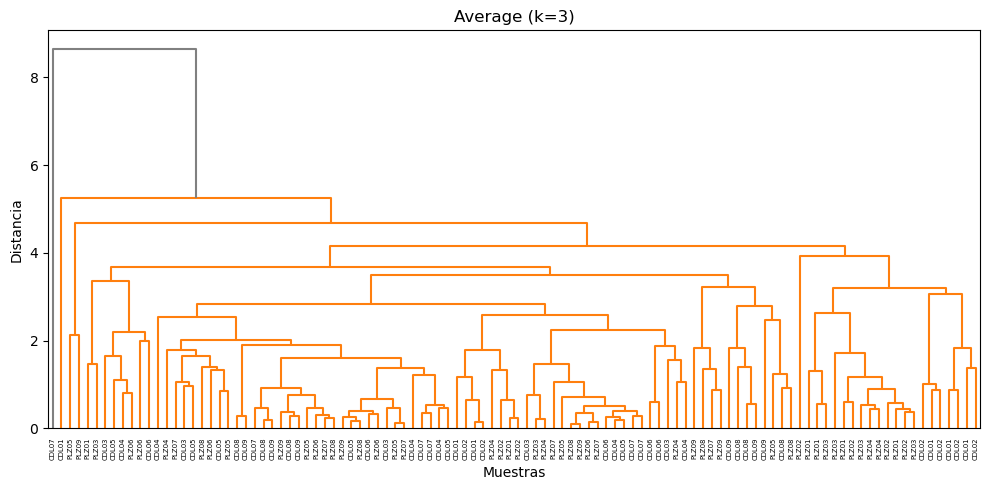

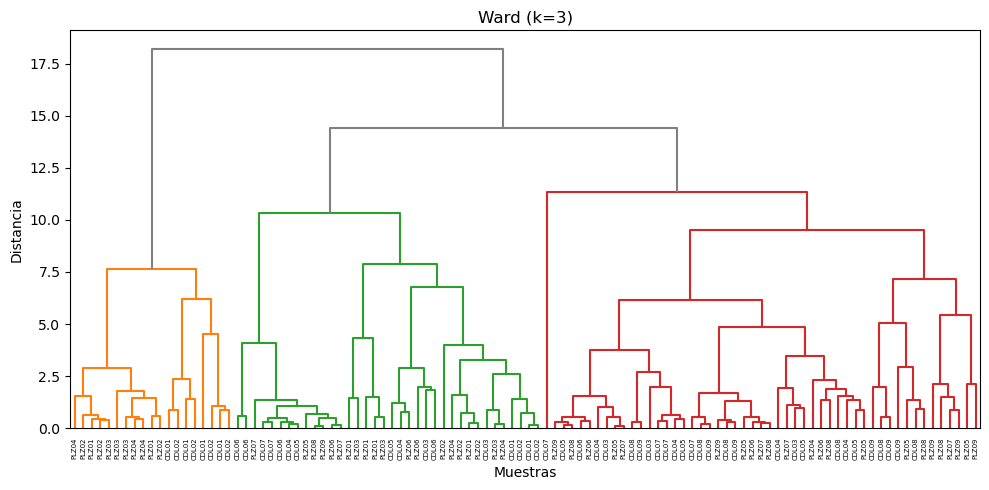

In [7]:
# Asegura etiquetas como lista
if 'station' in df_clean.columns:
    labels_k3 = df_clean['station'].astype(str).tolist()
else:
    labels_k3 = df_clean.index.astype(str).tolist()

metodos = ['single', 'complete', 'average', 'ward']
for m in metodos:
    Zm, _ = perform_hierarchical_clustering(X_scaled, method=m, n_clusters=3)
    plot_dendrogram(Zm, labels=labels_k3, n_clusters=3, title=f'{m.capitalize()} (k=3)')


## Conclusión

El análisis de clustering jerárquico permitió comparar cómo distintos métodos (`ward`, `single`, `complete`, `average`) agrupan las muestras del dataset.  
Con tres y cuatro clusters se observan diferencias claras en la estructura de los dendrogramas:  
- **Ward** tiende a formar grupos más equilibrados en tamaño.  
- **Single** genera cadenas más largas y tiende al efecto de "encadenamiento".  
- **Complete** produce clusters más compactos pero puede exagerar las distancias.  
- **Average** ofrece un resultado intermedio entre complete y single.  

En conjunto, este ejercicio mostró que la elección del número de clusters y del método de enlace influye de manera directa en la interpretación de los datos. Por ello, la técnica debe seleccionarse con base en los objetivos ecológicos o ambientales específicos del estudio.
